In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

from simulator.objects.market import Market
from simulator.objects.participant import Participant
from simulator.objects.policies.base_policy import BasePolicy
from simulator.objects.policies.ml_policy import MLPolicy, PassiveAggressivePolicy
from simulator.objects.policies.nn_policy import NNPolicy
from simulator.objects.stock import Portfolio, Stock, StockHolding

rng = default_rng()

In [2]:
def generate_stocks(n_stocks: int) -> list[Stock]:
    output: list[Stock] = []
    for _ in range(n_stocks):
        output.append(
            Stock(
                cash=rng.uniform(-10000, 30000, size=1)[0],
                earning_value_of_assets=rng.uniform(10000, 30000, size=1)[0],
                latest_quarterly_earnings=rng.uniform(10000, 30000, size=1)[0],
                price_history=np.ones(shape=(1825,)) * rng.uniform(10, 200, size=1)[0],
                quality_of_leadership=rng.uniform(0, 1, size=1)[0],
                stock_volatility=rng.uniform(0, 0.1, size=1)[0],
            )
        )
    return output

In [3]:
def generate_portfolio(stocks: list[Stock]) -> Portfolio:
    stock_holdings: list[StockHolding] = []
    for stock in stocks:
        stock_quantity: int = rng.choice(a=np.array([0, 0, 0, 1, 2, 3]), size=1)[0]
        if stock_quantity > 0:
            stock_holdings.append(
                StockHolding(
                    stock=stock,
                    stock_quantity=stock_quantity,
                )
            )
    return Portfolio(stock_holdings=stock_holdings)

In [4]:
def generate_participants(
    n_participants: int, stock_list: list[Stock], market: Market, policy: BasePolicy
) -> list[Participant]:
    output: list[Participant] = []
    for _ in range(n_participants):
        output.append(
            Participant(
                stock_portfolio=generate_portfolio(stock_list),
                policy=policy,
                cash=3000,
            )
        )
    return output

In [5]:
N_STOCKS = 100

market = Market(stocks=generate_stocks(N_STOCKS), interest_rate_apy=0.02)

In [6]:
# for _ in range(5000):
#     for stock in market.stocks:
#         stock.step()

In [7]:
# for i in range(50):
#     print(market.stocks[i].cash, market.stocks[i].earning_value_of_assets, market.stocks[i].quality_of_leadership)

In [8]:
market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            NNPolicy(
                market=market,
                n_stocks_to_sample=30,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("model2.pt"),
                valuation_model_noise_std=0.05,
            ),
        )[0]
        for _ in range(20)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            NNPolicy(
                market=market,
                n_stocks_to_sample=30,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("model_high_prices.pt"),
                valuation_model_noise_std=0.05,
            ),
        )[0]
        for _ in range(20)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            MLPolicy(
                market=market,
                n_stocks_to_sample=50,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("random_forest_regressor.pkl"),
            ),
        )[0]
        for _ in range(20)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            PassiveAggressivePolicy(
                market=market,
                n_stocks_to_sample=50,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("passive_aggressive.pkl"),
            ),
        )[0]
        for _ in range(20)
    ]
)

In [9]:
N_TIMESTEPS = 365

for i in range(N_TIMESTEPS):
    print(i)
    market.step_market()

0
Number of buy order stocks: 47
Number of sell order stocks: 69
Market total value: 11288.653515219132
1
Number of buy order stocks: 43
Number of sell order stocks: 70
Market total value: 12126.354754990598
2
Number of buy order stocks: 46
Number of sell order stocks: 71
Market total value: 13497.228932344027
3
Number of buy order stocks: 45
Number of sell order stocks: 75
Market total value: 14604.793891386189
4
Number of buy order stocks: 45
Number of sell order stocks: 80
Market total value: 15565.088819040797
5
Number of buy order stocks: 50
Number of sell order stocks: 79
Market total value: 16234.540442203914
6
Number of buy order stocks: 46
Number of sell order stocks: 82
Market total value: 16956.16968831729
7
Number of buy order stocks: 47
Number of sell order stocks: 82
Market total value: 17140.665645248562
8
Number of buy order stocks: 43
Number of sell order stocks: 81
Market total value: 17487.154390976022
9
Number of buy order stocks: 46
Number of sell order stocks: 80


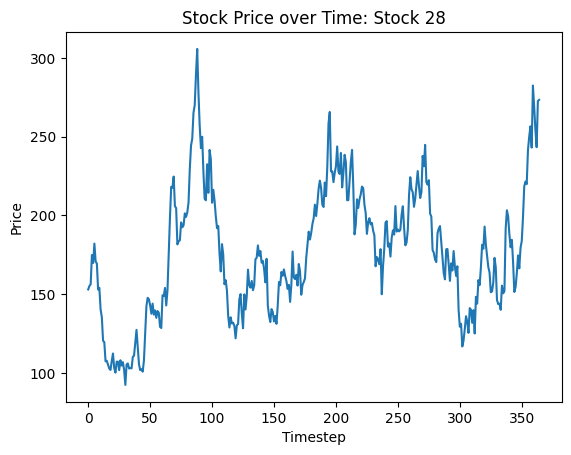

In [24]:
i = 28

plt.figure()
plt.plot(market.stocks[i].price_history[-N_TIMESTEPS:])
plt.title(f"Stock Price over Time: Stock {i}")
plt.xlabel("Timestep")
plt.ylabel("Price")
_ = plt.show()

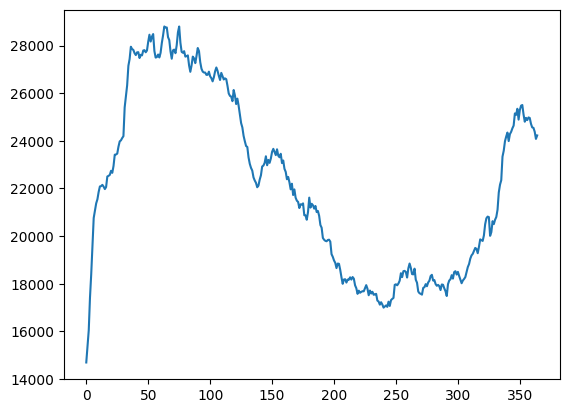

In [ ]:
i = 65

plt.figure()
plt.plot(market.participants[i].total_value[-N_TIMESTEPS:])
plt.title(f"Participant Value over Time: Participant {i}")
plt.xlabel("Timestep")
plt.ylabel("Total Value")
_ = plt.show()

In [12]:
percent_changes = []
for i in range(len(market.participants)):
    percent_changes.append(
        (
            market.participants[i].total_value[-1]
            - market.participants[i].total_value[-N_TIMESTEPS]
        )
        / market.participants[i].total_value[-N_TIMESTEPS]
    )

percent_changes_array = np.array(percent_changes)
relative_performance = percent_changes_array - np.mean(percent_changes_array)

nn_1_score = np.mean(relative_performance[:20])
nn_2_score = np.mean(relative_performance[20:40])
random_forest_score = np.mean(relative_performance[40:60])
passive_aggressive_score = np.mean(relative_performance[60:])

print(f"NN1: {nn_1_score}")
print(f"NN2: {nn_2_score}")
print(f"random forest: {random_forest_score}")
print(f"passive aggressive: {passive_aggressive_score}")

NN1: 0.005498895428646938
NN2: 0.18021364024795367
random forest: -0.028714234268039058
passive aggressive: -0.1569983014085617
